#### Runtime: Tensorflow 1.15 Python 3.6

## Loading Data From S3

In [2]:
!pip install patchify
!pip install segmentation-models==1.0.1
!pip install tensorflow
!pip install keras

  Using cached patchify-0.2.2-py3-none-any.whl (5.0 kB)
  Using cached scikit_image-0.17.2-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached tifffile-2020.9.3-py3-none-any.whl (148 kB)
  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Using cached PyWavelets-1.1.1-cp36-cp36m-manylinux1_x86_64.whl (4.4 MB)
  Using cached imageio-2.15.0-py3-none-any.whl (3.3 MB)
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached Pillow-8.4.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.1.1
    Uninstalling Pillow-8.1.1:
      Successfully uninstalled Pillow-8.1.1
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator

In [3]:
# Importing the Packages :
import os
import sys
import boto3
import subprocess
import io
import matplotlib.pyplot as plt
from patchify import patchify
import numpy as np
import segmentation_models as sm
from sklearn.model_selection import train_test_split


Segmentation Models: using `keras` framework.


In [4]:
#Loading The Data:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1'
#     aws_access_key_id = '******',
#     aws_secret_access_key = '******'
                    )


In [5]:
# Defining the Data Location in the S3 bucket :
default_location = 's3://appledatabucket-123/Apple/'
print(default_location)
print(os.listdir())
training_dir = 'Model'

s3://appledatabucket-123/Apple/
['Sagemaker_Deployment', 'Image_Segmentation.ipynb', '.git', 'requirements.txt', 'Image_Segmentation_Loading_S3.ipynb', '.ipynb_checkpoints', 'Image_Segmentation_old.ipynb', 'Notebook', 'Engine.py', 'README.md', 'MLPipeline']


## Getting Data From the Bucket

In [6]:
# Function To Load The Data
def loading_data(default_location):
    img_data_array = []
    mask_data_stack = []
    print("Reading the images")
    s3_bucket = "appledatabucket-123"
    keys = []
    for obj in s3.Bucket(s3_bucket).objects.all():
        keys.append(obj.key)
    for key in keys:
        file_stream = io.BytesIO()
        s3.Bucket(s3_bucket).Object(key).download_fileobj(file_stream)
        if ".jpg" in key and "Apple" in key:
            print(key)
            img = plt.imread(file_stream, format = 'jpg')
            print(img.shape)
            img_data_array.append(img)
        elif ".tiff" in key and "Apple" in key:
            print(key)
            mask = plt.imread(file_stream, format='tiff')
            print(mask.shape)
            mask_data_stack.append(mask)
    return img_data_array, mask_data_stack
     

In [7]:
# Getting Image and Mask:
img_data_array, mask_data_stack = loading_data(default_location)

Reading the images
Apple/1/1.jpg
(450, 720, 3)
Apple/1/1.tiff
(450, 720)
Apple/11/11.jpg
(406, 612, 3)
Apple/11/11.tiff
(406, 612)
Apple/12/12.jpg
(280, 334, 3)
Apple/12/12.tiff
(280, 334)
Apple/13/13.jpg
(216, 233, 3)
Apple/13/13.tiff
(216, 233)
Apple/14/14.jpg
(1300, 1300, 3)
Apple/14/14.tiff
(1300, 1300)
Apple/15/15.jpg
(153, 330, 3)
Apple/15/15.tiff
(153, 330)
Apple/16/16.jpg
(408, 612, 3)
Apple/16/16.tiff
(408, 612)
Apple/17/17.jpg
(606, 1024, 3)
Apple/17/17.tiff
(606, 1024)
Apple/18/18.jpg
(865, 1300, 3)
Apple/18/18.tiff
(865, 1300)
Apple/19/19.jpg
(866, 1300, 3)
Apple/19/19.tiff
(866, 1300)
Apple/2/2.jpg
(1000, 1778, 3)
Apple/2/2.tiff
(1000, 1778)
Apple/20/20.jpg
(957, 1300, 3)
Apple/20/20.tiff
(957, 1300)
Apple/21/21.jpg
(408, 612, 3)
Apple/21/21.tiff
(408, 612)
Apple/22/22.jpg
(1226, 1300, 3)
Apple/22/22.tiff
(1226, 1300)
Apple/23/23.jpg
(612, 612, 3)
Apple/23/23.tiff
(612, 612)
Apple/24/24.jpg
(443, 590, 3)
Apple/24/24.tiff
(443, 590)
Apple/25/25.jpg
(408, 612, 3)
Apple/25/25

In [8]:
print(len(img_data_array))
print(len(mask_data_stack))

24
24


## Patching the Images

In [9]:
# Functions to Patch the Images
def Image_Patching(img_data_array):
    all_img_patches = []
    shapes = []
    for img in range(len(img_data_array)):
        large_image = img_data_array[img]
        shapes.append(large_image.shape)
        patches_img = patchify(large_image, (128, 128, 3), step=128)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j , :, :]
                single_patch_img = (single_patch_img.astype('float32')) / 255.
                all_img_patches.append(single_patch_img)
    images = np.array(all_img_patches)
    images = np.reshape(images, (730, 128, 128, 3))
    return images
                

In [10]:
#Getting the Images Patches:
images = Image_Patching(img_data_array)

## Patching the Mask

In [11]:
# Functions to Patch the Maskes:
def Mask_Patching(mask_data_stack):
    all_mask_patches = []
    shapes =[]
    for img in range(len(mask_data_stack)):
        large_mask = mask_data_stack[img]
        shapes.append(large_mask.shape)
        patches_mask = patchify(large_mask, (128, 128), step=128)
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i, j , :, :]
                single_patch_mask = single_patch_mask / 255.
                all_mask_patches.append(single_patch_mask)       
    masks = np.array(all_mask_patches)  
    masks = np.expand_dims(masks, -1)
    return masks
                

In [12]:
## Getting the Mask Patches:
masks = Mask_Patching(mask_data_stack)

In [13]:
# Printing the Shapes of Images:
print("---Shape of the Images and Masks---")
print(images.shape)
print(masks.shape)
print("Pixel values in the mask are: np.unique(masks)")

---Shape of the Images and Masks---
(730, 128, 128, 3)
(730, 128, 128, 1)
Pixel values in the mask are: np.unique(masks)


In [14]:
#Building the Model:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
images1 = preprocess_input1(images) # Preprocessing the Image data in corresponding to the 'Resnet34' specification.
print(images1.shape)
print(masks.shape)

(730, 128, 128, 3)
(730, 128, 128, 1)


## Splitting the Dataset

In [15]:
# Splitting Data to Train and Test:
X_train, X_test, y_train, y_test = train_test_split(images1,
                                                   masks,
                                                   test_size=0.25,
                                                   random_state=42)

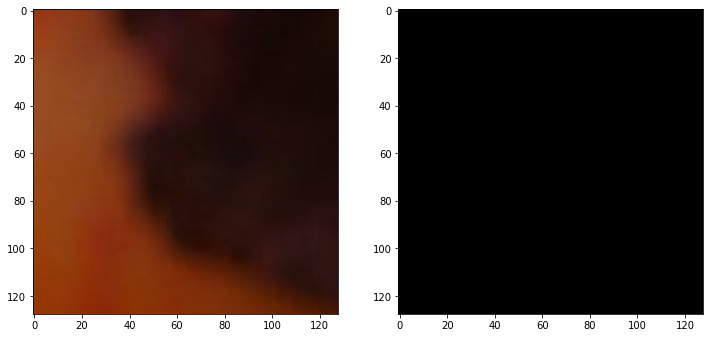

In [16]:
# Sanity check, view a few images
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)),cmap='gray')
plt.show()


### Augmentation of Images and Patches

In [17]:
seed =24 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Defining the ImageDataGenerator Parameters:

img_data_gen_args = dict(rotation_range = 90,
                        width_shift_range = 0.3,
                        height_shift_range = 0.3,
                        shear_range = 0.5,
                        zoom_range = 0.3,
                        horizontal_flip = True,
                        vertical_flip = True,
                        fill_mode = 'reflect')

mask_data_gen_args = dict(rotation_range = 90,
                        width_shift_range = 0.3,
                        height_shift_range = 0.3,
                        shear_range = 0.5,
                        zoom_range = 0.3,
                        horizontal_flip = True,
                        vertical_flip = True,
                        fill_mode = 'reflect',
                        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))




In [18]:
# Putting Images to the Generator for Augementation:
image_data_generator = ImageDataGenerator(**img_data_gen_args) # Initialising the Image Generator Model
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)  

In [19]:
#Putting Masks to the Generator for Augmentation:

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

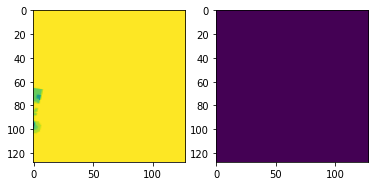

In [20]:
x = image_generator.next()
y = mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [21]:
def image_mask_generator(image_generator, mask_generator):
        train_generator = zip(image_generator, mask_generator)
        for (img, mask) in train_generator:
            yield (img, mask)

train_data_generator = image_mask_generator(image_generator, mask_generator)

validation_datagen = image_mask_generator(valid_img_generator, valid_mask_generator)

In [22]:
# Defining the Model:
print("Loading the Model.....")
    
sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#printing the Model:
print(model.summary())

Loading the Model.....
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
_____________________________________________________________________

In [23]:
steps_epoch=50
valid_step=50
epochs=50

In [24]:
# Training :
history = model.fit(train_data_generator,
                        validation_data = validation_datagen,
                        steps_per_epoch = steps_epoch,
                        validation_steps= valid_step,
                        epochs= epochs)

Epoch 1/50
50/50 [==============================] - 288s 6s/step - loss: 1.1188 - iou_score: 0.2473 - val_loss: 1436782.1250 - val_iou_score: 0.1681
Epoch 2/50
50/50 [==============================] - 278s 6s/step - loss: 0.7729 - iou_score: 0.4243 - val_loss: 77116.5469 - val_iou_score: 0.1651
Epoch 3/50
50/50 [==============================] - 276s 6s/step - loss: 0.6718 - iou_score: 0.4997 - val_loss: 46113.4453 - val_iou_score: 0.1725
Epoch 4/50
50/50 [==============================] - 277s 6s/step - loss: 0.6029 - iou_score: 0.5587 - val_loss: 966.8029 - val_iou_score: 0.1682
Epoch 5/50
50/50 [==============================] - 282s 6s/step - loss: 0.6603 - iou_score: 0.5267 - val_loss: 95.2213 - val_iou_score: 0.1652
Epoch 6/50
50/50 [==============================] - 278s 6s/step - loss: 0.6564 - iou_score: 0.5075 - val_loss: 1.6473 - val_iou_score: 0.0207
Epoch 7/50
50/50 [==============================] - 282s 6s/step - loss: 0.6018 - iou_score: 0.5570 - val_loss: 2.1851 - val_

KeyboardInterrupt: 

In [ ]:
def iou_score(model):
        y_pred = model.predict(X_test)
        y_pred_thresholded = y_pred > 0.5
        intersection = np.logical_and(y_test, y_pred_thresholded)
        union = np.logical_or(y_test, y_pred_thresholded)
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score

In [ ]:
score = iou_score(model)
print("IoU socre is: ", score)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

#Printing the IOU Score

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)

plt.show()